In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys

In [3]:
default_color_list = plt.rcParams['axes.prop_cycle'].by_key()['color'] # get default colors

In [4]:
"""Generate parameter constraints with emcee and Gaussian Processes."""

import emcee
# import sys
import stats_utils

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import sem as sem

PS_SCALE = 1e-9  # a number to multiply PS, to make it order unity

gp_list = []
def build_GP(params, ell, ps_mean):
    """
    Build a function that interpolates using GP.

    Returns
    -------
        function which takes in cosmological parameters, outputs interpolation

    """
    global gp_list
    gp_list = []
    for test_ell_bin in range(len(ell)):
        X = np.array([stats_utils.table['M_nu(eV)'],
                      stats_utils.table['Omega_m'],
                      stats_utils.table['10^9*A_s']])
        X = np.atleast_2d(X).T
        y = np.array([np.mean(ps_temp, axis=0)[test_ell_bin]
                      for ps_temp in ps_mean]) / PS_SCALE
        dy = np.array([sem(ps_temp, axis=0)[test_ell_bin]
                       for ps_temp in ps_mean]) / PS_SCALE
        kernel = C(1.0, (1e-3, 1e3)) * RBF(np.ones(3), (1e-3, 1e3))
        gp = GaussianProcessRegressor(kernel=kernel,
                                      alpha=(dy)**2,
                                      n_restarts_optimizer=10,
                                      normalize_y=True)
        gp.fit(X, y)
        gp_list.append(gp)

    def get_PS_(x):
        y_pred_list = []
        sigma_list = []
        for gp in gp_list:
            y_pred, sigma = gp.predict(np.atleast_2d(x), return_std=True)
            y_pred_list.append(y_pred[0])
            sigma_list.append(sigma[0])

        return np.array(y_pred_list), np.array(sigma_list)

    return get_PS_


# load up a parameter table
params = np.array([stats_utils.table['M_nu(eV)'],
                   stats_utils.table['Omega_m'],
                   stats_utils.table['10^9*A_s']])

# stitch together the realizations from different redshifts
ell = []
ps_real = []
redshifts = ['05', '10', '15', '20', '25']

for redshift in redshifts:
    ell_, ps_real_ = stats_utils.get_real_list('PS', noisy='K',
                                               redshift=redshift,
                                               bin_min=300, bin_max=5000,
                                               smoothing='1.00',
                                               binscale='log')
    ell.append(ell_)
    ps_real.append(ps_real_)

ell = np.hstack(ell)
ps_real = np.dstack(ps_real)

# load the inverse covariance, and then train the Gaussian Process
invcov = (PS_SCALE**2)*stats_utils.get_invcov('PS', noisy='K',
                                              redshifts=redshifts,
                                              bin_min=300, bin_max=5000,
                                              smoothing='1.00', binscale='log')
fid = np.mean(ps_real[1], axis=0) / PS_SCALE
get_PS = build_GP(params, ell, ps_real)

# set up some constants for prior evaluation
m_nu_min = np.min(stats_utils.table['M_nu(eV)'])
m_nu_max = np.max(stats_utils.table['M_nu(eV)'])
om_m_min = np.min(stats_utils.table['Omega_m'])
om_m_max = np.max(stats_utils.table['Omega_m'])
A_s_min = np.min(stats_utils.table['10^9*A_s'])
A_s_max = np.max(stats_utils.table['10^9*A_s'])


# define emcee function calls, prior, likelihood,
def lnprior(theta):
    """Ensure the sampler stays near computed simulations."""
    m_nu, om_m, A_s = theta
    if (m_nu_min < m_nu < m_nu_max and
            om_m_min < om_m < om_m_max and
            A_s_min < A_s < A_s_max):
        return 0.0
    return -np.inf


def lnlike(theta):
    """Compute the log likelihood based on multivariate Gaussian."""
    model, sig = get_PS(theta)
    dmu = fid - model
    return -0.5 * (np.dot(dmu, np.dot(invcov, dmu)))


def lnprob(theta):
    """Combine the likelihood and prior."""
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)


# set up emcee
ndim, nwalkers = 3, 100
p0 = [params.T[1] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

nr 9999 nb 120 bin 0.9878975795159032 sky 0.001225


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.56046605e+00, 4.90102917e-04, 3.84610891e-03, 3.10767442e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 15, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.56375892,  0.00162004, -0.00367269, -0.0048712 ]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 96, 'nit': 24, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.49209524e+00, -1.46707520e-03,  1.04176998e-03,  1.12229586e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, '

In [9]:

lnprob([0.1, 0.3, 2.1])

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


-27.88188603943726

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


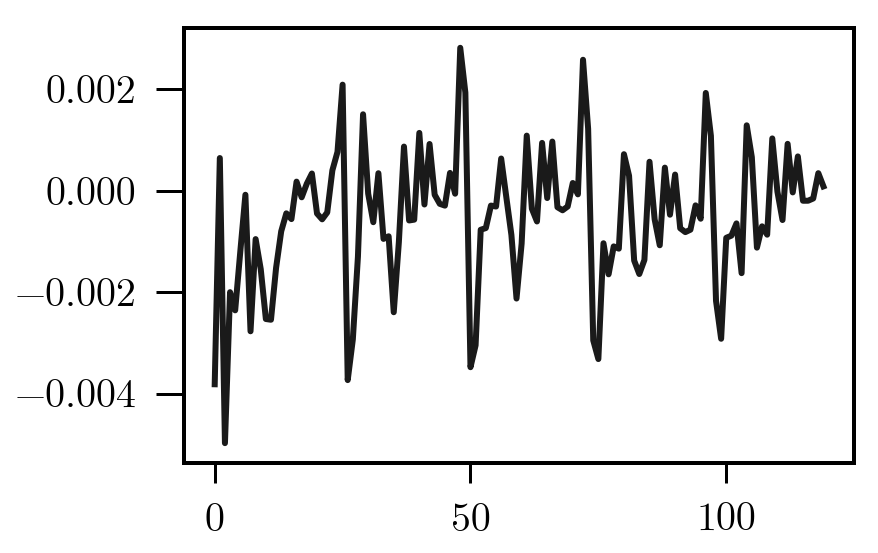

In [14]:
ys, sigs = get_PS([0.1, 0.3, 2.1])
plt.plot( (ys - fid)/fid )

In [ ]:
def get_invcov_real(observable_name, noisy, redshifts, smoothing, bin_min, bin_max,
               binning='050', binscale='', bin_center_row=0, sky_coverage=1e4, cov_model=0,
               verbose=True):
    
    ell = []
    ps_real = []
    for redshift in redshifts:
        ell_, ps_real_ = stats_utils.get_real_list(observable_name, noisy=noisy,
                                                   redshift=redshift,
                                                   bin_min=bin_min, bin_max=bin_max,
                                                   smoothing=smoothing,
                                                   binscale=binscale, cov=True)
        ell.append(ell_)
        ps_real.append(ps_real_)

    ell = np.hstack(ell)
    ps_real = np.dstack(ps_real)[cov_model,:,:]
    print(ps_real.shape)
    cov = np.cov(ps_real.T)

    nrealizations, nbins = ps_real.shape
    bin_correction = (nrealizations - nbins - 2) / (nrealizations - 1)
    sky_correction = 12.25/sky_coverage

    if verbose:
        print('nr', nrealizations, 'nb', nbins,
              'bin', bin_correction, 'sky', sky_correction)

    # this 12.25/2e4 is from the LSST area divided by box, from Jia's email
    invcov = bin_correction * np.linalg.inv(cov * sky_correction)

    return invcov

In [ ]:
c_1 = stats_utils.get_invcov('PS', noisy='K',
                       redshifts=redshifts,
                       bin_min=300, bin_max=5000,
                       smoothing='1.00', binscale='log')

In [11]:
%%time

nsteps = 500
width = 30
for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
    n = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[##############################]
CPU times: user 14h 29min 25s, sys: 15h 13min 33s, total: 1d 5h 42min 58s
Wall time: 55min 48s


In [50]:
np.max( (c_1 - c_2) / c_2 )

2.276095846272773e-08

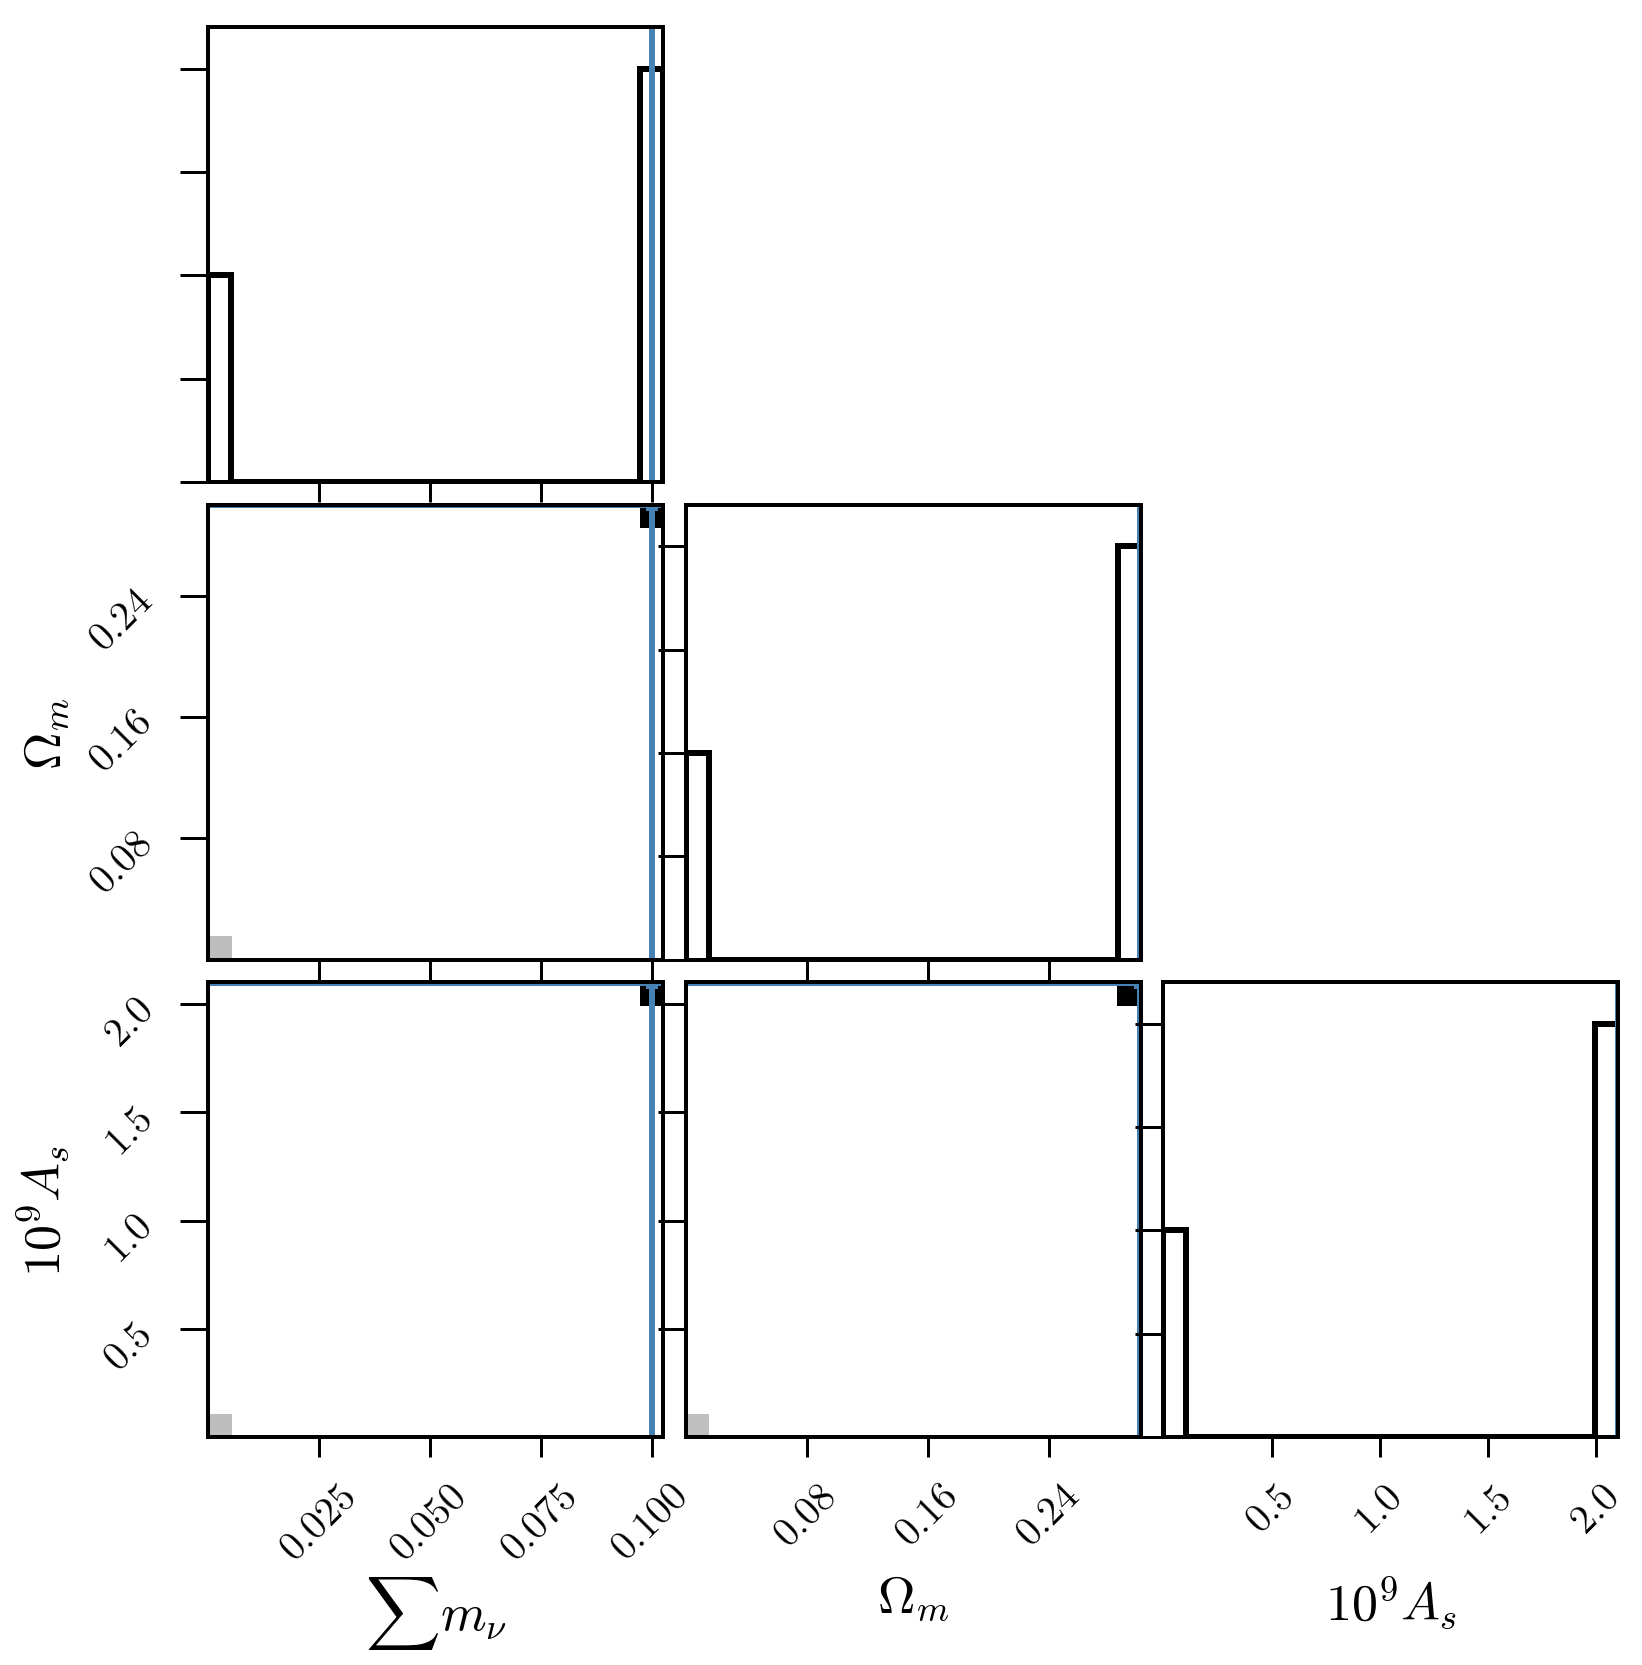

In [12]:
import corner
fig, axes = plt.subplots(3,3, figsize=(12,12))
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=[r"$\sum m_{\nu}$", r"$\Omega_m$", r"$10^9 A_s$"],
                      truths=params.T[1], fig=fig, levels=(0.68, 0.95))

-0.12066066573556128